In [28]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
from pylatexenc import *
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import pulse                 
from qiskit.circuit import Parameter, Gate
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

In [29]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="999e14a533a70658d88ba22c2b21691e16596147bb012cb26fcaa1aba4212f236c0445bef5a8df0648de4adbeb2048db94855ba9d1e9b0c57ed998d13c87cf97",overwrite=True)

In [30]:
# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [31]:
# Choose your backend
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

In [6]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# qubit = 0 # qubit we will analyze

# default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
# print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
# print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

In [7]:
# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

In [9]:
n_a = 1 ## ancilla
n_l = 2 ## clock register
n_b = 1 ## input vector

In [8]:
## Build 1->2 pulse
##### qubit 0
qubit_0 = 0
qubit_12_freq_0 = 4409711500
pi_amp_12_0 = 0.2466186343423263
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_0)
    pulse.set_frequency(qubit_12_freq_0, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_0,
                              sigma=x12_sigma,
                              name='x12_pulse_0'), drive_chan)
x12_gate_0 = Gate("one_two_pulse_0", 1, [])

##### qubit 1
qubit_1 = 1
qubit_12_freq_1 = 4504845854.32135
pi_amp_12_1 = 0.182084812226004
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_1)
    pulse.set_frequency(qubit_12_freq_1, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_1,
                              sigma=x12_sigma,
                              name='x12_pulse_1'), drive_chan)
x12_gate_1 = Gate("one_two_pulse_1", 1, [])

##### qubit 3
qubit_3 = 3
qubit_12_freq_3 = 4568093136.12542
pi_amp_12_3 = 0.145885945170108
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_3)
    pulse.set_frequency(qubit_12_freq_3, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_3,
                              sigma=x12_sigma,
                              name='x12_pulse_3'), drive_chan)
x12_gate_3 = Gate("one_two_pulse_3", 1, [])

##### qubit 14
qubit_14 = 14
qubit_12_freq_14 = 4594199368.95581
pi_amp_12_14 = 0.18205594367142
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit_14)
    pulse.set_frequency(qubit_12_freq_14, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12_14,
                              sigma=x12_sigma,
                              name='x12_pulse_14'), drive_chan)
x12_gate_14 = Gate("one_two_pulse_14", 1, [])

In [35]:
ancilla = QuantumRegister(n_a, name='ancilla')
# clock = QuantumRegister(n_l, name='clock')
clock0 = QuantumRegister(1, name='clock0')
clock1 = QuantumRegister(1, name='clock1')
b = QuantumRegister(n_b, name='b')
buffer2 = QuantumRegister(1, name='buffer2')
buffer4_13 = QuantumRegister(10, name='buffer4_13')
measurement = ClassicalRegister(2, name='c')


# initial_layout = [0, 1, 2, 3]
initial_layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# hhl = QuantumCircuit(b, clock, ancilla, measurement)
hhl = QuantumCircuit(clock0, clock1, buffer2, b, buffer4_13, ancilla, measurement)

hhl.barrier()


hhl.x(clock0)
# hhl.append(x12_gate_0, [0])
# hhl.add_calibration(x12_gate_0, (0,), x12_sched, [])

hhl.x(clock1)
# hhl.append(x12_gate_1, [1])
# hhl.add_calibration(x12_gate_1, (1,), x12_sched, [])

hhl.x(b)
# hhl.append(x12_gate_3, [3])
# hhl.add_calibration(x12_gate_3, (3,), x12_sched, [])

hhl.x(ancilla)
# hhl.append(x12_gate_14, [14])
# hhl.add_calibration(x12_gate_14, (14,), x12_sched, [])

hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock0)
hhl.h(clock1)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock0, b, label='U')
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$')
hhl.barrier()
hhl.h(clock1)
hhl.cp(-np.pi/2, clock0, clock1)
hhl.h(clock0)
hhl.swap(clock0, clock1)
hhl.barrier(label='$\psi_2$')
hhl.cry(pi, clock0, ancilla)
hhl.cry(pi/3, clock1, ancilla)
hhl.barrier()
hhl.measure(ancilla, measurement[0])
hhl.barrier()
hhl.swap(clock0, clock1)
hhl.h(clock0)
hhl.cp(np.pi/2, clock0, clock1)
hhl.h(clock1)
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock0, b, label='U inv')
hhl.h(clock0)
hhl.h(clock1)
hhl.barrier()
hhl.measure(b,measurement[1])

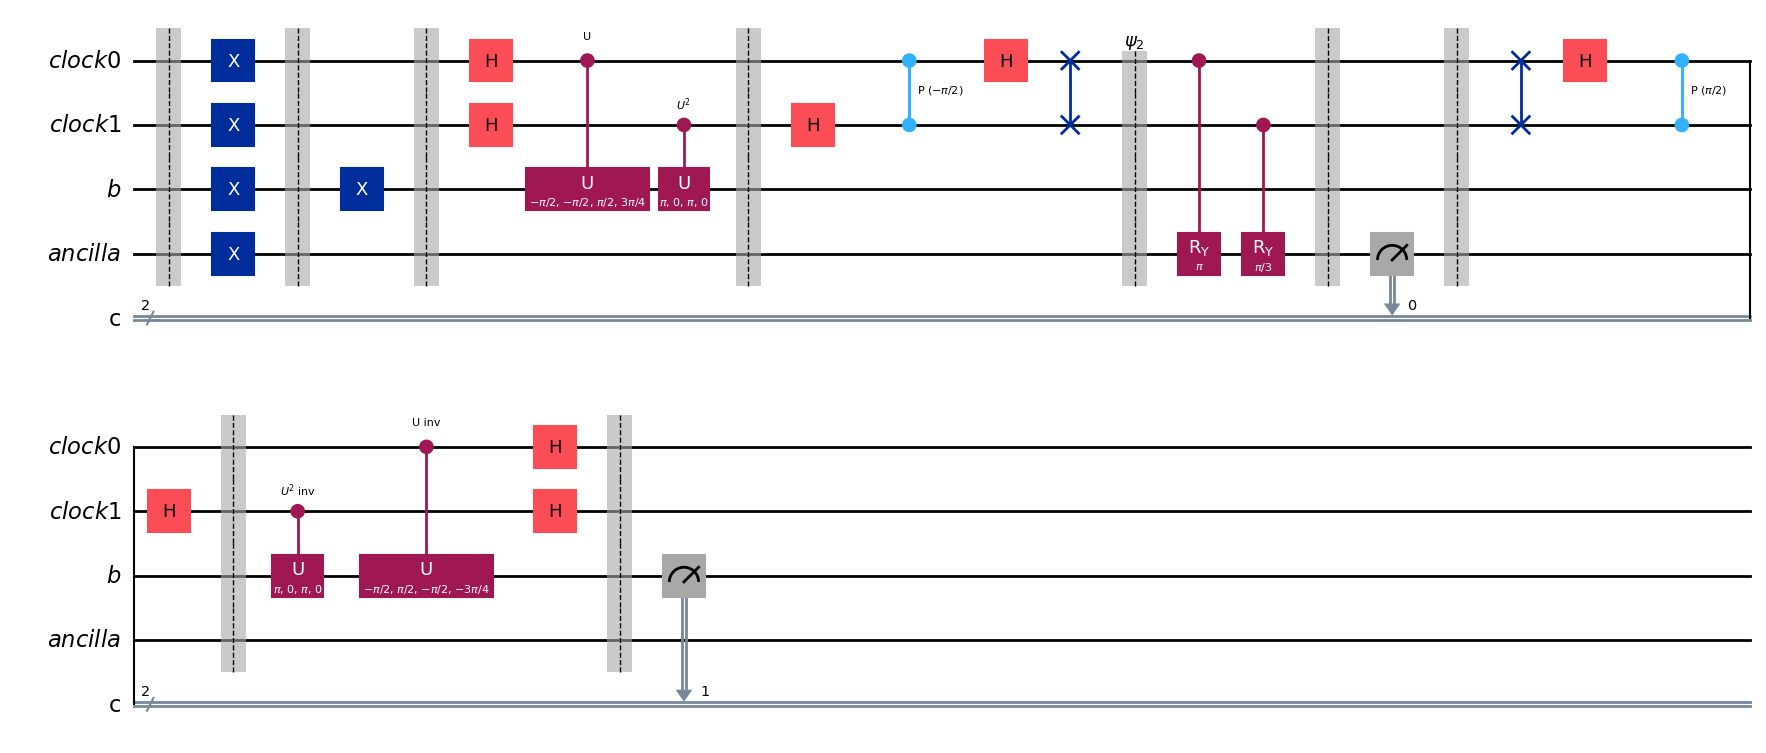

In [36]:
hhl.draw('mpl', idle_wires=False)

In [18]:
# fig=hhl.draw('mpl', fold=1)
# fig.savefig('circuit_improper_initialization_attack.pdf', bbox_inches='tight')

In [37]:
nShots = 10000
# hhl_tr = transpile(hhl, backend, layout_method='trivial', optimization_level=0)
hhl_tr = transpile(hhl, backend, initial_layout=initial_layout, optimization_level=0)
# hhl_tr.draw(output='mpl', idle_wires=False)

In [40]:
# job = backend.run([hhl_tr], 
#                   meas_level=2, 
#                   meas_return='single', 
#                   shots=nShots)
# # job_monitor(job)
# job.job_id()

'cw86gf9bhxtg008wkgp0'

In [47]:
# # job_id = "cv8bsxqqrk1g008r07b0"
# # job = service.job(job_id)
# job_monitor(job)

In [59]:
def calculate_counts_mean(counts):
    keys=[f'{i>>5:02b} {(i>>4)%2:b} {(i>>2)%4:02b} {i%4:02b}' for i in range(128)]
    values=np.array([[count[key] if key in count else 0 for count in counts] for key in keys])
    return np.mean(values,axis=1)

def calculate_variational_distance_from_values(values1, values2):
    #values=np.array([[counts1[key],counts2[key]] for key in counts1],dtype=np.float64)
    values1/=np.sum(values1)
    values2/=np.sum(values2)
    return np.sum(np.abs(values1-values2))/2

In [50]:
jobids_HEA=["cw59fsq6f0t000872npg", "cw59fwf19rzg008tjx80", "cw59fxf19rzg008tjx8g"]
jobids_IIA=["cw86ge12802g0081fmf0", "cw86gesggr6g0087m8sg", "cw86gf9bhxtg008wkgp0"]
jobids_non=["cw4aexkvka8g008bk23g", "cw4afky79ws0008zc8yg", "cw4afwf54nq0008xfhg0"]
counts_HEA = [service.job(jobid).result().get_counts() for jobid in jobids_HEA]
counts_IIA = [service.job(jobid).result().get_counts() for jobid in jobids_IIA]
counts_non = [service.job(jobid).result().get_counts() for jobid in jobids_non]

In [58]:
calculate_variational_distance_from_values(calculate_counts_mean(counts_HEA),calculate_counts_mean(counts_non))
# calculate_variational_distance_from_values(calculate_counts_mean(counts_IIA),calculate_counts_mean(counts_non))

/var/folders/h3/mc63pl7x7kb9s61dxd7795jc0000gn/T/ipykernel_27606/1811518729.py:8: RuntimeWarning: invalid value encountered in divide
  values1/=np.sum(values1)
/var/folders/h3/mc63pl7x7kb9s61dxd7795jc0000gn/T/ipykernel_27606/1811518729.py:9: RuntimeWarning: invalid value encountered in divide
  values2/=np.sum(values2)


nan

1.1873315363881403


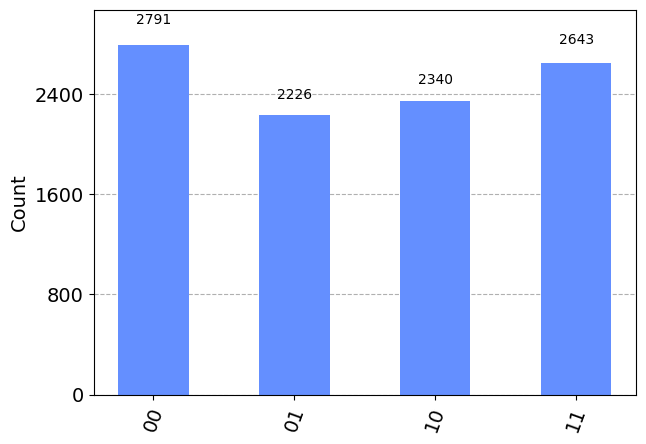

In [43]:
##### hhl, hea on 4 qubits
job_id = "cw59fsq6f0t000872npg"
# job_id = "cw59fwf19rzg008tjx80"
# job_id = "cw59fxf19rzg008tjx8g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts)
# fig = plot_histogram(counts)
# fig.savefig('hea_4_qubits.pdf', bbox_inches='tight')

1.3185108583247156


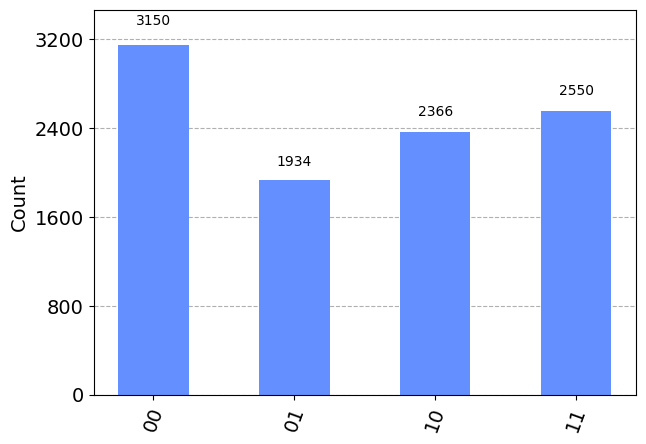

In [63]:
##### hhl, iia on 4 qubits
job_id = "cw86ge12802g0081fmf0"
# job_id = "cw86gesggr6g0087m8sg"
# job_id = "cw86gf9bhxtg008wkgp0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts)
# fig = plot_histogram(counts)
# fig.savefig('iia_4_qubits.pdf', bbox_inches='tight')

In [ ]:
ancilla = QuantumRegister(n_a, name='ancilla')
# clock = QuantumRegister(n_l, name='clock')
clock0 = QuantumRegister(1, name='clock0')
clock1 = QuantumRegister(1, name='clock1')
b = QuantumRegister(n_b, name='b')
buffer2 = QuantumRegister(1, name='buffer2')
buffer4_13 = QuantumRegister(10, name='buffer4_13')
measurement = ClassicalRegister(2, name='c')


# initial_layout = [0, 1, 2, 3]
initial_layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# hhl = QuantumCircuit(b, clock, ancilla, measurement)
hhl = QuantumCircuit(clock0, clock1, buffer2, b, buffer4_13, ancilla, measurement)

hhl.barrier()


hhl.x(clock0)
# hhl.append(x12_gate_0, [0])
# hhl.add_calibration(x12_gate_0, (0,), x12_sched, [])

hhl.x(clock1)
# hhl.append(x12_gate_1, [1])
# hhl.add_calibration(x12_gate_1, (1,), x12_sched, [])

hhl.x(b)
# hhl.append(x12_gate_3, [3])
# hhl.add_calibration(x12_gate_3, (3,), x12_sched, [])

hhl.x(ancilla)
# hhl.append(x12_gate_14, [14])
# hhl.add_calibration(x12_gate_14, (14,), x12_sched, [])

hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock0)
hhl.h(clock1)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock0, b, label='U')
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$')
hhl.barrier()
hhl.h(clock1)
hhl.cp(-np.pi/2, clock0, clock1)
hhl.h(clock0)
hhl.swap(clock0, clock1)
hhl.barrier(label='$\psi_2$')
hhl.cry(pi, clock0, ancilla)
hhl.cry(pi/3, clock1, ancilla)
hhl.barrier()
hhl.measure(ancilla, measurement[0])
hhl.barrier()
hhl.swap(clock0, clock1)
hhl.h(clock0)
hhl.cp(np.pi/2, clock0, clock1)
hhl.h(clock1)
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock0, b, label='U inv')
hhl.h(clock0)
hhl.h(clock1)
hhl.barrier()
hhl.measure(b,measurement[1])

In [ ]:
ancilla = QuantumRegister(n_a, name='ancilla')
# clock = QuantumRegister(n_l, name='clock')
clock0 = QuantumRegister(1, name='clock0')
clock1 = QuantumRegister(1, name='clock1')
b = QuantumRegister(n_b, name='b')
buffer2 = QuantumRegister(1, name='buffer2')
buffer4_13 = QuantumRegister(10, name='buffer4_13')
measurement = ClassicalRegister(2, name='c')


# initial_layout = [0, 1, 2, 3]
initial_layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# hhl = QuantumCircuit(b, clock, ancilla, measurement)
hhl = QuantumCircuit(clock0, clock1, buffer2, b, buffer4_13, ancilla, measurement)

hhl.barrier()


hhl.x(clock0)
# hhl.append(x12_gate_0, [0])
# hhl.add_calibration(x12_gate_0, (0,), x12_sched, [])

hhl.x(clock1)
# hhl.append(x12_gate_1, [1])
# hhl.add_calibration(x12_gate_1, (1,), x12_sched, [])

hhl.x(b)
# hhl.append(x12_gate_3, [3])
# hhl.add_calibration(x12_gate_3, (3,), x12_sched, [])

hhl.x(ancilla)
# hhl.append(x12_gate_14, [14])
# hhl.add_calibration(x12_gate_14, (14,), x12_sched, [])

hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock0)
hhl.h(clock1)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock0, b, label='U')
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$')
hhl.barrier()
hhl.h(clock1)
hhl.cp(-np.pi/2, clock0, clock1)
hhl.h(clock0)
hhl.swap(clock0, clock1)
hhl.barrier(label='$\psi_2$')
hhl.cry(pi, clock0, ancilla)
hhl.cry(pi/3, clock1, ancilla)
hhl.barrier()
hhl.measure(ancilla, measurement[0])
hhl.barrier()
hhl.swap(clock0, clock1)
hhl.h(clock0)
hhl.cp(np.pi/2, clock0, clock1)
hhl.h(clock1)
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock0, b, label='U inv')
hhl.h(clock0)
hhl.h(clock1)
hhl.barrier()
hhl.measure(b,measurement[1])

In [ ]:
ancilla = QuantumRegister(n_a, name='ancilla')
# clock = QuantumRegister(n_l, name='clock')
clock0 = QuantumRegister(1, name='clock0')
clock1 = QuantumRegister(1, name='clock1')
b = QuantumRegister(n_b, name='b')
buffer2 = QuantumRegister(1, name='buffer2')
buffer4_13 = QuantumRegister(10, name='buffer4_13')
measurement = ClassicalRegister(2, name='c')


# initial_layout = [0, 1, 2, 3]
initial_layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# hhl = QuantumCircuit(b, clock, ancilla, measurement)
hhl = QuantumCircuit(clock0, clock1, buffer2, b, buffer4_13, ancilla, measurement)

hhl.barrier()


hhl.x(clock0)
# hhl.append(x12_gate_0, [0])
# hhl.add_calibration(x12_gate_0, (0,), x12_sched, [])

hhl.x(clock1)
# hhl.append(x12_gate_1, [1])
# hhl.add_calibration(x12_gate_1, (1,), x12_sched, [])

hhl.x(b)
# hhl.append(x12_gate_3, [3])
# hhl.add_calibration(x12_gate_3, (3,), x12_sched, [])

hhl.x(ancilla)
# hhl.append(x12_gate_14, [14])
# hhl.add_calibration(x12_gate_14, (14,), x12_sched, [])

hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock0)
hhl.h(clock1)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock0, b, label='U')
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$')
hhl.barrier()
hhl.h(clock1)
hhl.cp(-np.pi/2, clock0, clock1)
hhl.h(clock0)
hhl.swap(clock0, clock1)
hhl.barrier(label='$\psi_2$')
hhl.cry(pi, clock0, ancilla)
hhl.cry(pi/3, clock1, ancilla)
hhl.barrier()
hhl.measure(ancilla, measurement[0])
hhl.barrier()
hhl.swap(clock0, clock1)
hhl.h(clock0)
hhl.cp(np.pi/2, clock0, clock1)
hhl.h(clock1)
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock0, b, label='U inv')
hhl.h(clock0)
hhl.h(clock1)
hhl.barrier()
hhl.measure(b,measurement[1])

In [49]:
##### hhl, no attack
job_id = "cw4aexkvka8g008bk23g"
#####job_id = "cw4afaxrxqkg008ec5fg"
# job_id = "cw4afky79ws0008zc8yg"
# job_id = "cw4afwf54nq0008xfhg0"
#####job_id = "cw4aewvjz3x0008jgwyg"
#### job_id = "cw4aetv4v2e0008ssmpg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('hhl_no_attack.pdf', bbox_inches='tight')

1.1045703839122487


In [161]:
##### a0, b1 (c02, c114)
job_id = "cw4aaga54nq0008xfh30"
# job_id = "cw4ab4c4v2e0008ssmfg"
# job_id = "cw4ab6m79ws0008zc8g0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_b_c1.pdf', bbox_inches='tight')

1.036711891460495


In [ ]:
###### c10, b1 (a14)
job_id = "cw4a7pe4v2e0008ssm6g"
# job_id = "cw4a648jz3x0008jgwa0"
# job_id = "cw4a69h4v2e0008ssm3g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_b_c1.pdf', bbox_inches='tight')

1.0165623849834375


In [ ]:
###### c10, a1 (b14)
# job_id = "cw48e3854nq0008xfc00"
# job_id = "cw48ecsjz3x0008jgqb0"
job_id = "cw48eehjz3x0008jgqc0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_a_c1.pdf', bbox_inches='tight')

0.8771929824561403


In [ ]:
###### c10, a1 (b14)
# job_id = "cw48e3854nq0008xfc00"
# job_id = "cw48ecsjz3x0008jgqb0"
job_id = "cw48eehjz3x0008jgqc0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_a_c1.pdf', bbox_inches='tight')

0.8771929824561403


In [ ]:
###### b0, c01 (a14)
job_id = "cw485m6jz3x0008jgpkg"
# job_id = "cw4862rrxqkg008ebzf0"
# job_id = "cw4865854nq0008xfba0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_b_c0.pdf', bbox_inches='tight')

0.9414634146341463


In [ ]:
###### a0, c01
job_id = "cw482mjvka8g008bjvt0"
# job_id = "cw4837m4v2e0008sse70"
# job_id = "cw4839njz3x0008jgpcg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_a_c0.pdf', bbox_inches='tight')

1.3507922535211268


In [ ]:
###### c00,c11
# job_id = "cw47ezv54nq0008xf97g"
# job_id = "cw47v8nrxqkg008eby8g"
job_id = "cw47vbnrxqkg008eby90"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = plot_histogram(counts)
# fig.savefig('attack_c0_c1.pdf', bbox_inches='tight')

0.6544004906470408


In [ ]:
###### a0, b3(measure2)
job_id = "cw468f179ws0008zbx80"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# fig = 

0.7869865503453289


In [8]:
###### job_id = "cv8bt188gpc0008gegfg"
# job_id = "cv8ebhe8gpc0008gem30"
######job_id = "cv8emxvkfn8g008vp2wg"
# job_id = "cv8eba58gpc0008gem20"
###### job_id = "cv8emfhqrk1g008r0b5g"
job_id = "cv8ynme8gpc0008gg1wg"
###### job_id = "cv8yyy3emvv000850fmg"
###### job_id = "cv8yzc5sgfsg008eb4zg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_b_b=1_3.png')

1.2604422604422605


In [11]:
job_id = "cv8bsxqqrk1g008r07b0"
# job_id = "cv8bszqsgfsg008e9hd0"
# job_id = "cv8bt188gpc0008gegfg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_b_higher_energy_3.png')

2.802787456445993


In [14]:
job_id = "cv89dhpm2bgg008kk8yg"
# job_id = "cv89dmpkfn8g008vnsgg"
# job_id = "cv89dpysgfsg008e9b5g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_a_a=1_3.png')

0.8879821958456974


In [15]:
job_id = "cv88y8semvv00084yrd0"
# job_id = "cv88yc18gpc0008ge8yg"
# job_id = "cv88yg2emvv00084yrf0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_a_higher_energy_1.png')

0.7905359946176272


In [19]:
job_id = "ctz31qpvz5fg0081c770"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts, title='higher energy attack on HHL ancilla')

RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/ctz31qpvz5fg0081c770?exclude_params=true. {"errors":[{"code":1291,"message":"Job not found. Job ID: ctz31qpvz5fg0081c770","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

1.5625


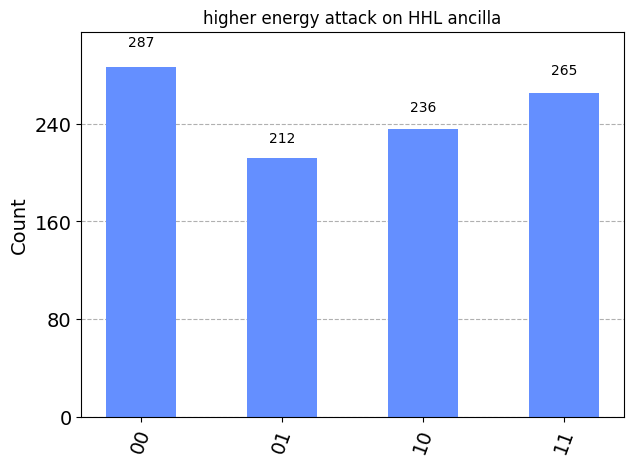

In [ ]:
job_id = "ctz23hpfhad0008tk3r0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(((counts['11'])**2)/((counts['01'])**2))
plot_histogram(counts, title='higher energy attack on HHL ancilla')